# Technical analysis 

Appropriate processing and denoising of the trading data could help create effective trading strategy. 

Here is a board range of indicators found under the TA-LIB. 


In [64]:
# supress warnings
import warnings
warnings.filterwarnings('ignore')

In [65]:
# Load liabilies 
%matplotlib inline 

from pathlib import Path
import numpy as np
import pandas as pd
import pandas_datareader.data as web

import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
from sklearn.preprocessing import scale
import talib

import matplotlib.pyplot as plt
import seaborn as sns

In [66]:
#format 

sns.set_style('whitegrid')
idx = pd.IndexSlice
deciles = np.arange(.1, 1, .1).round(1)

# Load data

In [67]:
data = pd.read_hdf('data.h5', 'data/top500')
price_sample = pd.read_hdf('data.h5', 'data/sample')
start_year = '2012'
end_year = '2013'

#  Simple Moving average (SMA)

Smooth out the values in a finite window. 
For the price series (P) with a window window of length (N), the simple moving average at time (t) weights each data point within the window has equal weight.

In [68]:
df = price_sample.loc[start_year:end_year, ['close']]

In [69]:
for t in [5, 21, 63]:
    df[f'SMA_{t}'] = talib.SMA(df.close, timeperiod=t)

Text(0.5, 0, '')

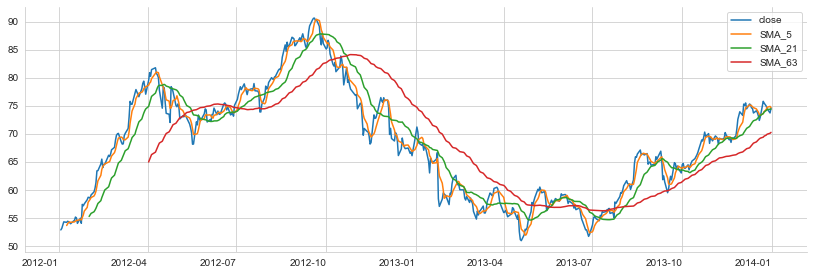

In [70]:
fig_width=14
fig_height=5

ax = df.plot(figsize=(fig_width, fig_height), rot=0)
sns.despine()
ax.set_xlabel('')

# Exponential moving average (EMA)

For the price series (P) with a window length (N), the exponential moving average at time (t) is recusively defined as the weighted average of the current price and previous (EMA_t-1). 

In [71]:
df = price_sample.loc[start_year:end_year, ['close']]

In [72]:
for t in [5, 21, 63]:
    df[f'EMA{t}'] = talib.EMA(df.close, timeperiod=t)

Text(0.5, 0, '')

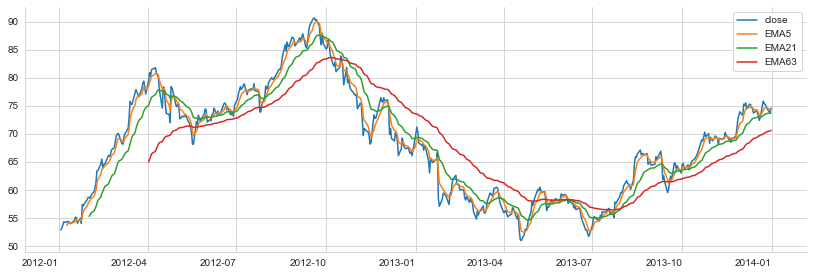

In [73]:
ax = df.plot(figsize=(fig_width, fig_height), rot=0)
sns.despine()
ax.set_xlabel('')

# Kaufman Adaptive Moving Average (KAMA)

The KAMA aims to take into account of chnages in market volatility


In [74]:
df = price_sample.loc[start_year:end_year, ['close']]

In [75]:
for t in [5, 21, 63]:
    df[f'KAMA{t}'] = talib.KAMA(df.close, timeperiod=t)

Text(0.5, 0, '')

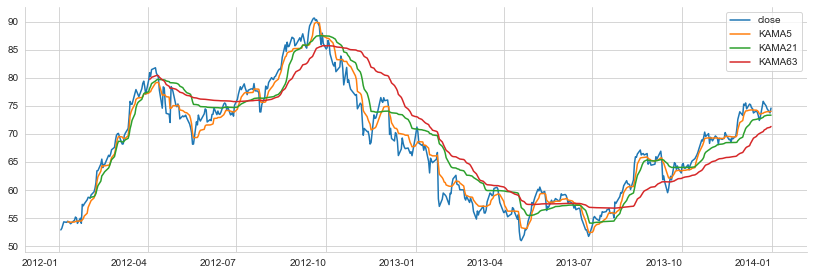

In [76]:
ax = df.plot(figsize=(fig_width, fig_height), rot=0)
sns.despine()
ax.set_xlabel('')

# Comparison of SMA, EMA, KAMA

In [77]:
df = price_sample.loc[start_year:end_year, ['close']]
t = 21 

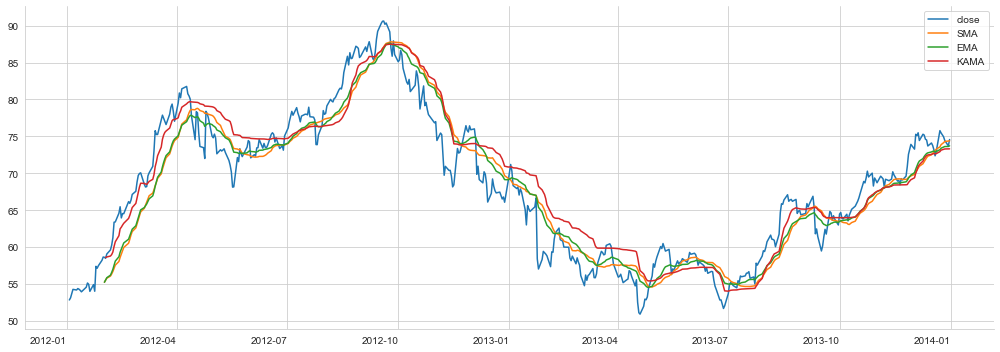

In [78]:
df['SMA'] = talib.SMA(df.close, timeperiod=t)
df['EMA'] = talib.EMA(df.close, timeperiod=t)
df['KAMA'] = talib.KAMA(df.close, timeperiod=t)

ax = df[['close', 'SMA', 'EMA', 'KAMA']].plot(figsize=(fig_width, fig_height), rot=0)

sns.despine()
ax.set_xlabel('')
plt.tight_layout()

# Overlap Studies 

Bollinger Bands (BBANDS)
Parabolic SAR (SAR)


# Bollinger Bands (BBANDS)

In [79]:
s = talib.BBANDS(df.close,   # Number of periods (2 to 100000)
                 timeperiod=20,
                 nbdevup=2,    # Deviation multiplier for lower band
                 nbdevdn=2,    # Deviation multiplier for upper band
                 matype=1      # default: SMA
                 )

In [80]:
df = price_sample.loc[start_year:end_year, ['close']]

In [81]:
bb_bands = ['upper', 'middle', 'lower']
df = df.assign(**dict(zip(bb_bands,s))) #pass keyword arguments parameter as a dictionary.
ax = df.loc[:, ]

# Parabolic SAR 

The Parabolic SAR aims to identify trend reversals. It is a trend following indicator could be used to set a tralling stop loss or entry points. 


In [82]:
df = price_sample.loc[start_year:end_year, ['close', 'high', 'low']]

In [83]:
df['SAR'] = talib.SAR(df.high,df.low,
acceleration=0.02,
maximum=0.2)

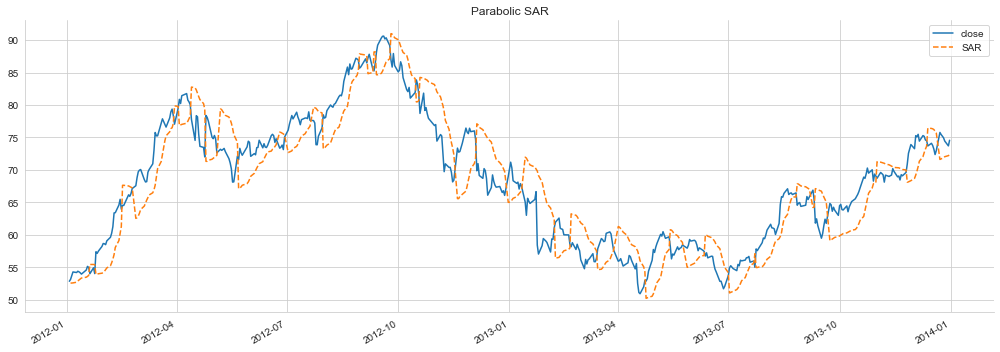

In [84]:
ax = df[['close', 'SAR']].plot(figsize=(fig_width, fig_height), style=['-', '--'], title='Parabolic SAR')

ax.set_xlabel('')
sns.despine()
plt.tight_layout()


# Normalized SAR indicator 

In [85]:
def compute_sar_indicator(x, acceleration=.02,maximum=0.2):
    sar = talib.SAR(x.high,
                    x.low,
                    acceleration=acceleration,
                    maximum=maximum)
    return sar/x.close - 1                


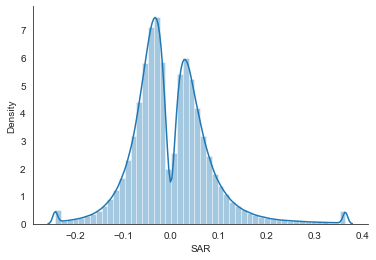

In [86]:
data['SAR'] = (data.groupby(level='ticker',group_keys=False).apply(compute_sar_indicator))

q = 0.005

with sns.axes_style('white'):
    sns.distplot(data.SAR.clip(data.SAR.quantile(q), data.SAR.quantile(1-q)))
    sns.despine()

# Momentum indicators

# Moving Average Convergence/Divergence (MACD)

MACD is a trend-following momentum indicator that shows the relationship between two moving averages of a security's price. It is calculated by subtracting the 26-period Exponential Moving Average (EMA) from the 12-period EMA. 


In [87]:
df = price_sample.loc[start_year:end_year, ['close']]

In [88]:
macd, macdsignal, macdhist = talib.MACD(df.close,
                                        fastperiod=12,
                                        slowperiod=26,
                                        signalperiod=9)

df['MACD'] = macd
df['MACDSIG'] = macdsignal
df['MACDHIST'] = macdhist

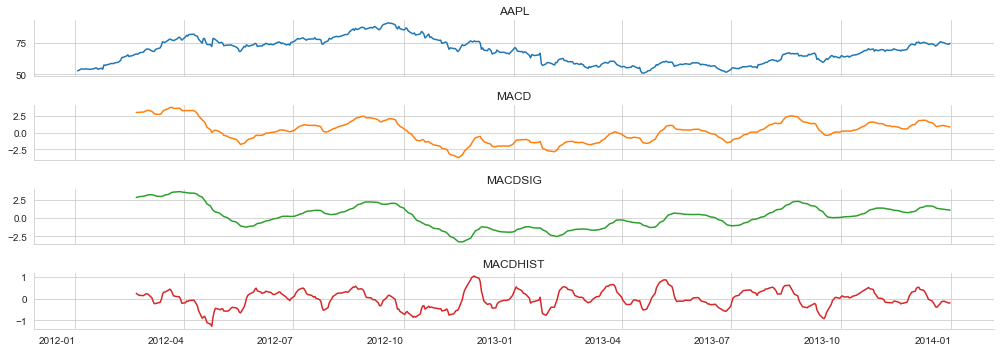

In [89]:
axes = df.plot(figsize=(fig_width, fig_height), 
                rot=0,
                subplots=True,
                title=['AAPL', 'MACD', 'MACDSIG', 'MACDHIST'],
                legend=False)

axes[-1].set_xlabel('')
sns.despine()
plt.tight_layout()

# Relative Strength Index 

RSI compares the magnitude of recent price changes across stocks to identify stocks as overbought or oversold. A high RSI (>70) indicates oevr brough and a low RSI (<30) indicates oversold. 

In [90]:
df = price_sample.loc[start_year:end_year, ['close']]

In [91]:
df['RSI'] = talib.RSI(df.close, timeperiod=14)

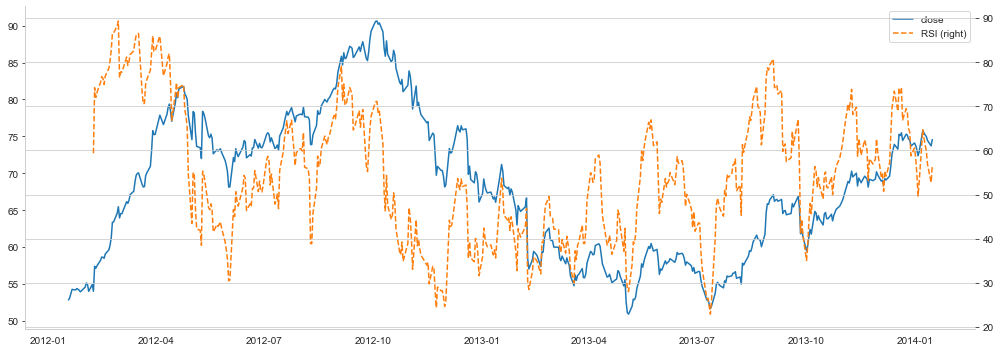

In [92]:
ax = df.plot(figsize=(fig_width, fig_height), rot=0, secondary_y=['RSI'], style=['-', '--'])
ax.set_xlabel('')
sns.despine()
plt.tight_layout()

# Stochastic RSI (STOCHRSI)

The STOCHRSI is based on the RSI just described ans intends to identiy crossovers as wel as overbought and oversold conditions. It compares the distance of the current RSI to the lowest RSI over a given time period (t) to the maximum range of values the RSI for this period.

The return series (fastk) is the unsmoothed RSI. The (fastd_period) is used to compute a smoothed 


In [93]:
df = price_sample.loc[start_year:end_year, ['close']]

In [94]:
fastk, fastd = talib.STOCHRSI(df.close,
                                timeperiod=14,
                                fastk_period=14,
                                fastd_period=3,
                                fastd_matype=0)

df['fastk'] = fastk
df['fastd'] = fastd

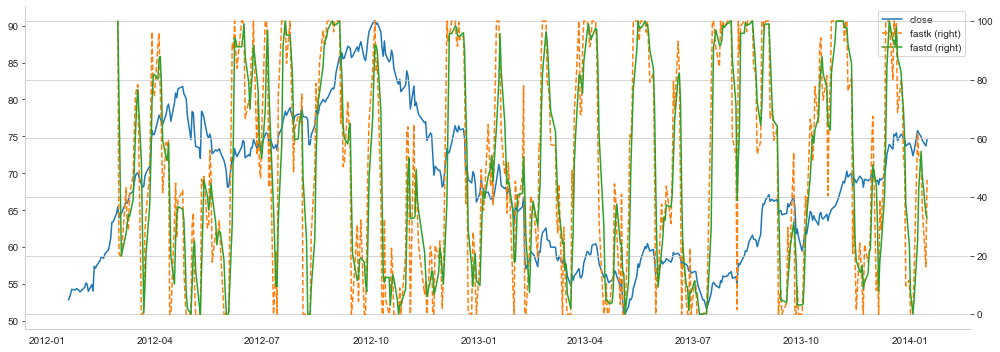

In [95]:
ax = df.plot(figsize=(fig_width, fig_height),
            rot=0,
            secondary_y=['fastk', 'fastd'],
            style=['-', '--'])
ax.set_xlabel('')
sns.despine()
plt.tight_layout()

In [96]:
# Volume Indicators 

# Chaikin A/D Line

The Chaikin Advance/Decline is a volume-based indicator designed to measure the cumulative flow of money into and out of an asset. The indicator assumes hte degree of buying or selling pressure can be dtermined by the location of the close, relative to he high and low for the period. There is buying (selling) pressure when a stock closes in the upper (lower) half of a period's range. 

In [97]:
df = price_sample.loc[start_year:end_year, ['high', 'low', 'close', 'volume']]

In [98]:
df['AD'] = talib.AD(df.high,
                    df.low,
                    df.close,
                    df.volume)

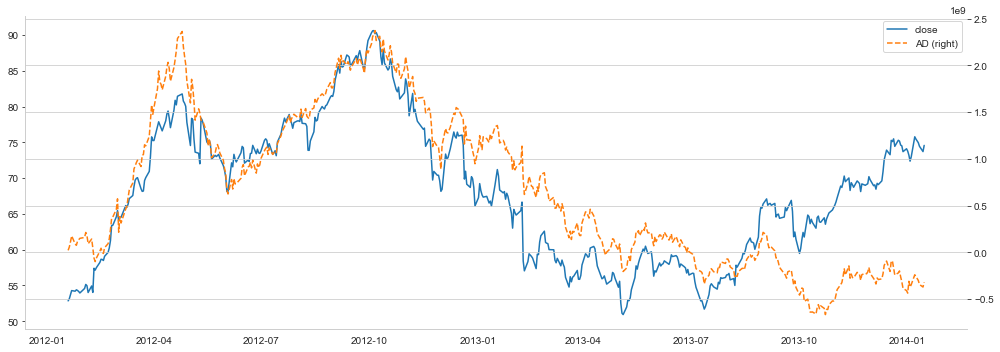

In [99]:
ax = df[['close', 'AD']].plot(figsize=(fig_width, fig_height),
                                rot=0,
                                secondary_y='AD',
                                style=['-', '--'])
ax.set_xlabel('')
sns.despine()
plt.tight_layout()

In [111]:
by_ticker = data.groupby('ticker', group_keys=False)

data['AD'] = by_ticker.apply(lambda x: talib.AD(x.high, x.low, x.close, x.volume)/x.volume.mean())

data.AD.replace((np.inf, -np.inf), np.nan).dropna().describe()

count    1.255093e+06
mean     3.820196e+01
std      4.457350e+01
min     -1.562873e+02
25%      5.206637e+00
50%      3.226342e+01
75%      6.711474e+01
max      2.413463e+02
Name: AD, dtype: float64

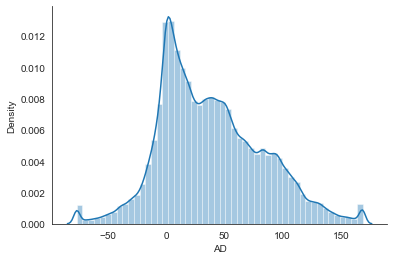

In [106]:
q = 0.005

AD = data.AD.replace((np.inf, -np.inf), np.nan).dropna()

with sns.axes_style('white'):
    sns.distplot(AD.clip(lower=AD.quantile(q),
                 upper=AD.quantile(1-q)))

    sns.despine()

# Divide by average volume to normalize across assets.

# Volatility indicators

# Average True Range Indicator (ATR) 

ATR shows volatility of the market. It aims to anticipate changes in trend such that the higher its value, the higher the probability of a trend change, the lower the indicator's value. the weaker the current trend. 

In [107]:
df = price_sample.loc[start_year:end_year, ['high', 'low', 'close']]

In [108]:
df['ATR'] = talib.ATR(df.high,
                        df.low,
                        df.close,
                        timeperiod=14)

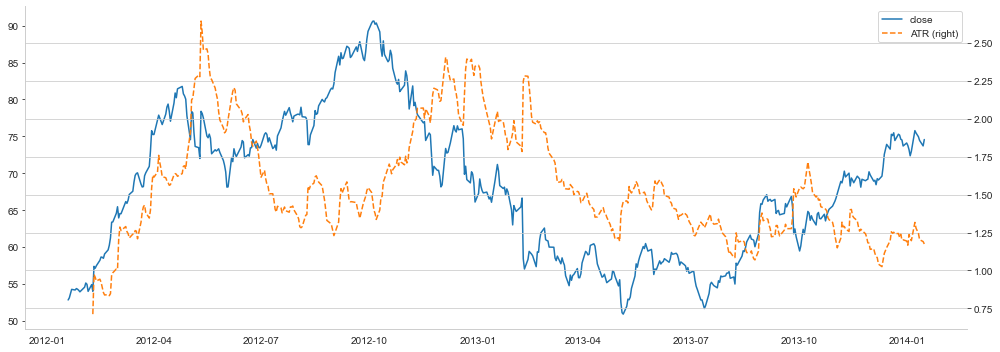

In [109]:
ax = df[['close', 'ATR']].plot(figsize=(fig_width, fig_height), 
                                rot=0,
                                secondary_y='ATR',
                                style=['-', '--'])
ax.set_xlabel('')
sns.despine()
plt.tight_layout()

# Compute normalized version of ATR using rolling mean of price 

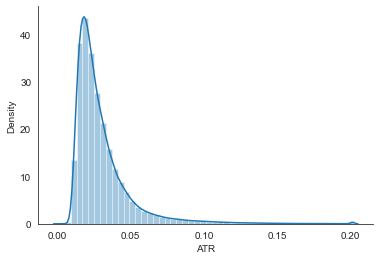

In [115]:
data['ATR'] = by_ticker.apply(lambda x: talib.ATR(x.high, x.low, x.close, timeperiod=14)/x.rolling(14).close.mean())

q = 0.001
with sns.axes_style('white'):
    sns.distplot(data.ATR.clip(upper=data.ATR.quantile(1-q)))
    sns.despine()